In [1]:
# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:

#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.



In [3]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('/content/drive/MyDrive/Colab Notebooks/fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' '
    output_sentence_input = ' ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


>>> s = "a,b,c,d\n"
>>> s.rstrip("\n").split(",")
['a', 'b', 'c', 'd']
RSPLIT USE

In [4]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  Beat it.
French translation:  Pars ! 


Tokenization and Padding

The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

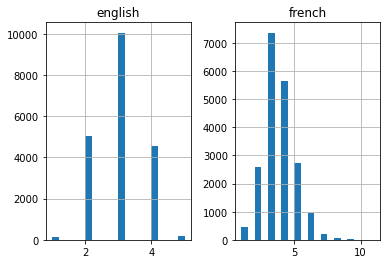

In [5]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))  

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

The histogram above shows maximum length of the French sentences is 12 and that of the English sentence is 6.

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

It divides a sentence into the corresponding list of word

Then it converts the words to integers

Also the word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values.

In [6]:

#tokenize the input sentences(input language) 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

[[17], [17], [17], [17], [528], [528], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [132], [61], [1434], [1434], [1434], [1201], [1201], [1201], [717], [58], [773], [773], [655], [655], [52], [52], [52], [106], [106], [106], [106], [106], [106], [106], [718], [718], [17, 43], [17, 43], [17, 43], [529], [529], [1, 63], [1, 63], [1, 81], [1, 182], [1, 182], [1, 182], [837, 34], [377], [377], [377], [377], [377], [377], [377], [377], [377], [377], [377], [377], [530], [530], [530], [245], [561], [561], [561], [561], [228, 4], [228, 4], [228, 4], [228, 4], [1202], [1202], [1202], [1202], [103, 4], [103, 4], [30, 33], [30, 33], [30, 33], [17, 73], [17, 73], [17, 73], [56, 4], [56, 4], [56, 4], [56, 4], [56, 4], [56, 4], [1771, 37], [1771, 37], [472, 8], [472, 8], [1, 305], [1, 305], [1, 2399], [1, 1772], [1, 74], [1, 144], [1, 144], [1, 378], [1, 84], [1, 317], [1, 317], [1, 317], [1, 1046], [1, 248], [1, 248], [7, 2400], [7, 141],

In [7]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#with open('output_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(output_tokenizer, handle, protocol=4)


[[48, 2], [551], [22, 458, 2], [426, 2], [691, 2], [4500], [2653], [2654], [125, 235, 1183, 18, 235, 1923, 2], [1480, 2], [1924, 2], [779, 2], [2655, 2], [2656, 2], [2653], [2654], [125, 235, 1183, 18, 235, 1923, 2], [1480, 2], [1924, 2], [779, 2], [2655, 2], [2656, 2], [33, 3], [26, 4501], [4502], [4503], [18, 4504], [4505], [4506], [61, 875, 2], [18, 2657], [4507], [4508], [1925], [1925], [26, 2658], [4509], [1481, 2], [276, 2], [348, 2], [998], [276, 2], [348, 2], [4510], [998], [1926], [2659], [4511], [4512], [4513], [999, 2], [691, 2], [1, 1000], [4514], [2660], [15, 395, 2], [1, 65, 1001, 2], [126, 378], [4515, 552, 2], [1184], [1927], [1928], [2661, 2662], [2663, 2664], [42, 1482], [1929, 2], [1185, 2], [2665], [1186, 2], [42, 182], [227], [4516], [2666, 93, 16, 1187], [4517], [1483, 3], [2667, 2], [4518, 2], [18, 4519, 2], [18, 4520], [4521, 2], [4522, 2], [4523, 2], [4524, 2], [1484, 2], [18, 67, 1484, 2], [379, 2], [4525, 2], [4526], [4527], [1930], [2668, 2], [298], [1931, 1

In [8]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (20000, 5)
encoder_input_sequences[180]: [  0   0   0 307   4]


In [9]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

474
57


In [10]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (20000, 11)
decoder_input_sequences[180]: [363   2   0   0   0   0   0   0   0   0   0]


In [11]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)


decoder_output_sequences.shape: (20000, 11)


Word Embeddings
We already converted our words into integers. So what's the difference between integer representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words. On the contrary, word embeddings retain relationships between the words. You can either use custom word embeddings or you can use pretrained word embeddings.

For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Recall that we have 9581 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.

In [13]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) +1)

embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector=embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] =embedding_vector

In [14]:
print(embeddings_dictionary["join"])

[-3.7239e-01  4.7634e-01 -1.9666e-01 -1.1641e+00  1.2820e-02 -4.7063e-01
  4.4522e-01  1.8911e-01  5.6740e-01 -6.1915e-02  2.7159e-01 -1.7613e-01
 -5.4897e-01 -1.6782e-01  3.0910e-01  1.0253e-01  4.3412e-01 -4.0300e-02
  3.4782e-02  2.8017e-01  1.6735e-01 -5.3730e-02 -5.9838e-01 -6.7251e-02
 -7.0371e-01  1.0674e+00  4.1123e-01  2.6227e-01 -3.2041e-01  5.2882e-01
  3.6446e-01  1.3661e-01 -2.2680e-01  6.6556e-01  3.4684e-01 -4.1284e-01
  5.5050e-01  3.5691e-01  3.6985e-01 -3.1312e-01  9.2343e-02  1.7105e-01
 -1.5200e-01  6.4297e-02  2.2327e-01  2.9222e-01 -7.3356e-01 -4.6585e-02
 -2.1011e-01  1.2690e-01  3.1638e-01 -5.1846e-01  2.2601e-02 -1.6426e-01
 -8.4231e-02 -6.5978e-02 -1.4436e-01 -2.2150e-01  4.2886e-01  3.0813e-01
 -1.0191e-03  5.9619e-01  1.7514e-01  5.3788e-01 -6.3198e-01  1.5236e-01
 -1.9268e-01  5.8482e-03  6.8425e-01  5.9576e-01  4.4315e-01  3.5061e-01
  1.8628e-01  8.6317e-01  2.1811e-01 -2.6925e-02  1.4113e-01 -6.5218e-03
 -1.8793e-01 -7.6275e-01 -1.9529e-01 -3.8076e-01  2

In [15]:
print(embedding_matrix[474])

[-3.72390002e-01  4.76339996e-01 -1.96659997e-01 -1.16410005e+00
  1.28199998e-02 -4.70629990e-01  4.45219994e-01  1.89109996e-01
  5.67399979e-01 -6.19149990e-02  2.71589994e-01 -1.76129997e-01
 -5.48969984e-01 -1.67820007e-01  3.09100002e-01  1.02530003e-01
  4.34119999e-01 -4.03000005e-02  3.47819999e-02  2.80169994e-01
  1.67349994e-01 -5.37299998e-02 -5.98380029e-01 -6.72509968e-02
 -7.03710020e-01  1.06739998e+00  4.11229998e-01  2.62270004e-01
 -3.20410013e-01  5.28819978e-01  3.64459991e-01  1.36610001e-01
 -2.26799995e-01  6.65560007e-01  3.46839994e-01 -4.12840009e-01
  5.50499976e-01  3.56909990e-01  3.69850010e-01 -3.13120008e-01
  9.23430026e-02  1.71049997e-01 -1.51999995e-01  6.42969981e-02
  2.23269999e-01  2.92219996e-01 -7.33560026e-01 -4.65850011e-02
 -2.10109994e-01  1.26900002e-01  3.16379994e-01 -5.18459976e-01
  2.26009991e-02 -1.64260000e-01 -8.42309967e-02 -6.59779981e-02
 -1.44360006e-01 -2.21499994e-01  4.28860009e-01  3.08129996e-01
 -1.01909996e-03  5.96189

You can see that the values for the 474th row in the embedding matrix are similar to the vector representation of the word join in the GloVe dictionary, which confirms that rows in the embedding matrix represent corresponding word embeddings from the GloVe word embedding dictionary. This word embedding matrix will be used to create the embedding layer for our LSTM model.

In [16]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [17]:
#(number of inputs, length of the output sentence, the number of words in the output)

In [18]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 11, 9582)

In [19]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

Next, we need to create the encoder and decoders. The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

In [20]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an token appended at the beginning.

In [21]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [22]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [23]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5, 200)       688000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 11, 256)      2452992     ['input_2[0][0]']                
                                                                                              

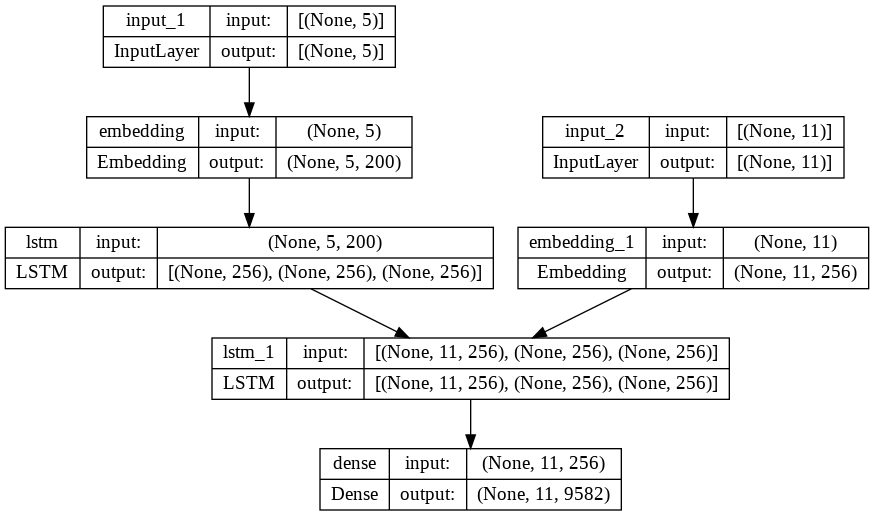

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [25]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [26]:

history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)

Epoch 1/20
282/282 [==============================] - 129s 444ms/step - loss: 1.9165 - accuracy: 0.7440 - val_loss: 1.6285 - val_accuracy: 0.7762
Epoch 2/20
282/282 [==============================] - 128s 452ms/step - loss: 1.0868 - accuracy: 0.8564 - val_loss: 1.2374 - val_accuracy: 0.8402
Epoch 2: early stopping


In [27]:
model.save('seq2seq_eng-fra.h5')

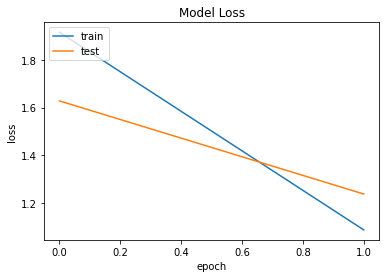

In [28]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:

encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-fra.h5')
     

In [30]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [31]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [32]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [33]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

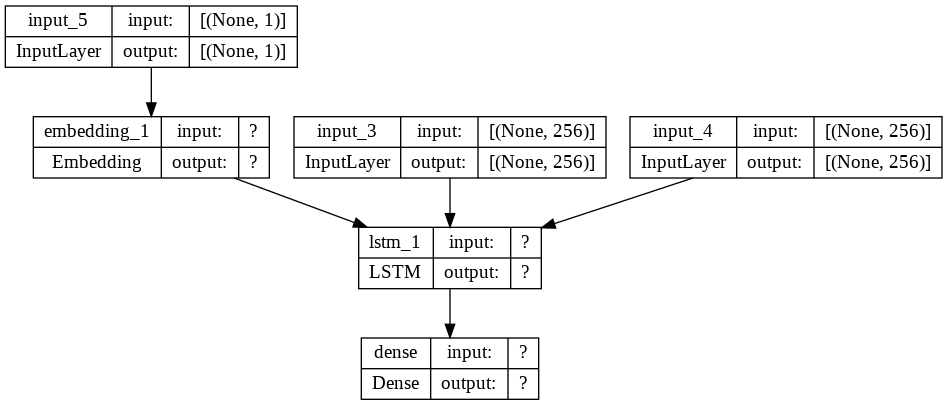

In [34]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

Making Predictions
we want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [35]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [36]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['']
    eos = word2idx_outputs['']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [38]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

1/1 [==============================] - 0s 17ms/step


KeyError: ignored